<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
This notebook computes DEGs and pathway enrichments

<strong>Input Data:</strong>

`stats_inputs.ipynb` outputs


In [1]:
library(edgeR)
library(sva)
library(fgsea)
library(tidyr)
source('../ABCA7lof2//degs.r')
set.seed(5)

ERROR: Error in library(edgeR): there is no package called 'edgeR'


In [ ]:
# check if output directory exists, if not create it, and download the necessary file in R

path <- "../../processed_data/"

if (!dir.exists(path)) {
  dir.create(path, recursive = TRUE)
}

url <- 'https://storage.googleapis.com/abca7lof/scRNAseq/processed_data/stats_input_data_0825.rds'
local_filename <- file.path(path, basename(url))

download.file(url, destfile = local_filename, mode = "wb")
cat("Download completed!\n")

#### Compute gene scores (DEGs)

In [2]:
all_data = readRDS('../processed_data/single_cell/stats_input_data_0825.rds')

In [3]:
summed_counts = all_data$summed_counts_by_ind 
meta = all_data$summary
meta$seq_batch = ifelse(meta$seq_batch=='JBM',1,0)
expressed = all_data$expressed10

In [4]:
# filter out individuals with too few cells per celltype
keep = summed_counts$ncells>=10
summed_counts_indexed = summed_counts$summed_counts[,keep]

In [11]:
if(sum(keep==FALSE)==0){
    print('NOT removing any samples')
}else{
    print(paste0('removing ',str( sum(keep==FALSE)), ' samples'))
}

[1] "NOT removing any samples"


In [7]:
# compute degs (all samples)
vars = c('LOF', 'amyloid', 'nft',  'msex', 'age_death', 'pmi', 'seq_batch', 'APOE4')
limma_inputs = get_limma_inputs(summed_counts_indexed, expressed, meta, vars)
aggs = limma_inputs$aggs
metadata = limma_inputs$metadata


degs_all = lapply(names(aggs)[!names(aggs)%in%c('Vascular')], function(x) RunDiffExprAnalysisLimma(aggs[[x]], metadata[[x]], n.sv=NULL))
names(degs_all) = names(aggs)[!names(aggs)%in%c('Vascular')]

Number of significant surrogate variables is:  10 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  9 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  5 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  7 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  9 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  7 
Iteration (out of 5 ):1  2  3  4  5  

Error in model for PALM2-AKAP2 : object 'PALM2' not found

Error in model for ERV3-1 : object 'ERV3' not found

Error in model for ERVK3-1 : object 'ERVK3' not found

`geom_smooth()` using formula = 'y ~ x'


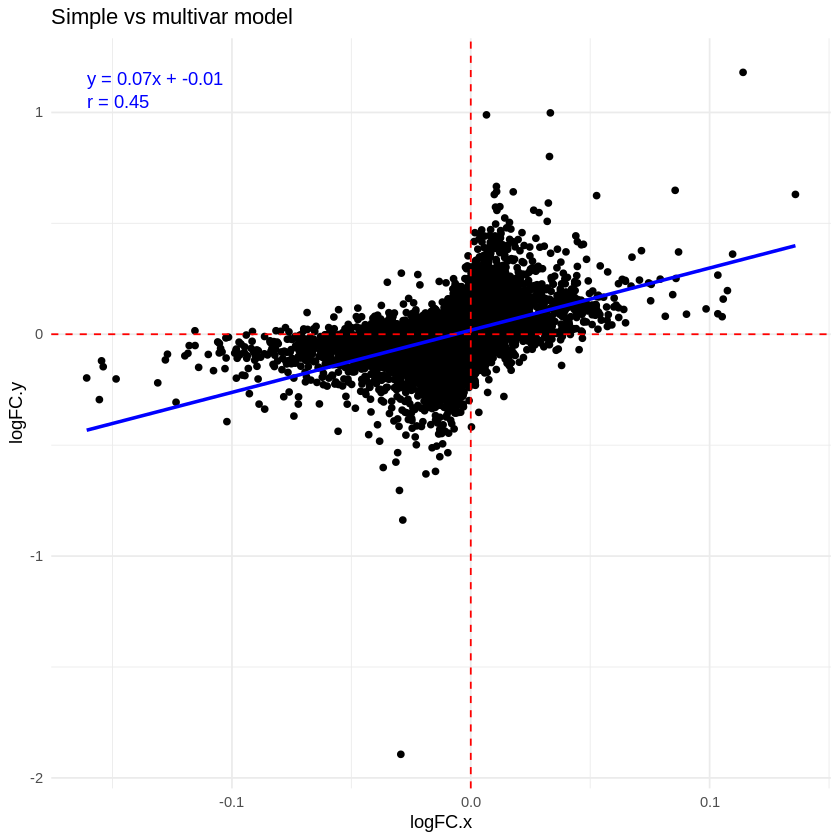

In [121]:
# sanity check Nr 1: simple model

f = all_data$av_logcounts_by_ind_full_matrix
f = f[,startsWith(colnames(f), 'Ex')]
colnames(f) = unlist(lapply(colnames(f), function(x) strsplit(x, 'Ex.')[[1]][2]))

d = t(f[,rownames(metadata$Ex)])
all_datax = merge(d, metadata$Ex, by = 0)
          
out = c()
for(i in row.names(degs_all$Ex$res)){
  # Construct the formula dynamically
  formula <- as.formula(paste(i, "~ LOF + amyloid + nft + msex + age_death + pmi + seq_batch + APOE4"))
  
  # Use tryCatch to handle errors
  tryCatch({
    # Fit the linear model
    model <- lm(formula, data = all_datax)
    
    # Extract the coefficient for 'LOF' and append it to the 'out' vector
    T = model$coefficients['LOF']
    names(T) = i
    out <- c(out, T)
  }, error = function(e) {
    # Print a message if there is an error
    message(paste("Error in model for", i, ":", e$message))
    # Continue the loop without appending any value
  })
}
                            
merged = merge(as.data.frame(out), degs_all$Ex$res, by = 0)

# Fit a linear model
model <- lm(out ~ logFC, data = merged)
formula <- paste0("y = ", round(coef(model)[2], 2), "x + ", round(coef(model)[1], 2))

# Calculate the correlation coefficient
correlation <- cor(merged$out, merged$logFC)
cor_text <- paste0("r = ", round(correlation, 2))

# Plot the data
ggplot(merged, aes(x = out, y = logFC)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +  # Add linear regression line
  geom_vline(xintercept = 0, linetype = "dashed", color = "red") +  # Vertical line at 0
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +  # Horizontal line at 0
  labs(title = "Simple vs multivar model",
       x = "logFC.x",
       y = "logFC.y") +
  annotate("text", x = min(merged$out), y = max(merged$logFC), label = formula, hjust = 0, vjust = 1, color = "blue") +  # Add formula annotation
  annotate("text", x = min(merged$out), y = max(merged$logFC) - 0.1, label = cor_text, hjust = 0, vjust = 1, color = "blue") +  # Add correlation coefficient annotation
  theme_minimal()


Warning message in sva(v$E, mod1, mod0, n.sv = n.sv):
“Returning zero surrogate variables as requested”
Warning message in sva(v$E, mod1, mod0, n.sv = n.sv):
“Returning zero surrogate variables as requested”
Warning message in sva(v$E, mod1, mod0, n.sv = n.sv):
“Returning zero surrogate variables as requested”
Warning message in sva(v$E, mod1, mod0, n.sv = n.sv):
“Returning zero surrogate variables as requested”
Warning message in sva(v$E, mod1, mod0, n.sv = n.sv):
“Returning zero surrogate variables as requested”
Warning message in sva(v$E, mod1, mod0, n.sv = n.sv):
“Returning zero surrogate variables as requested”
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


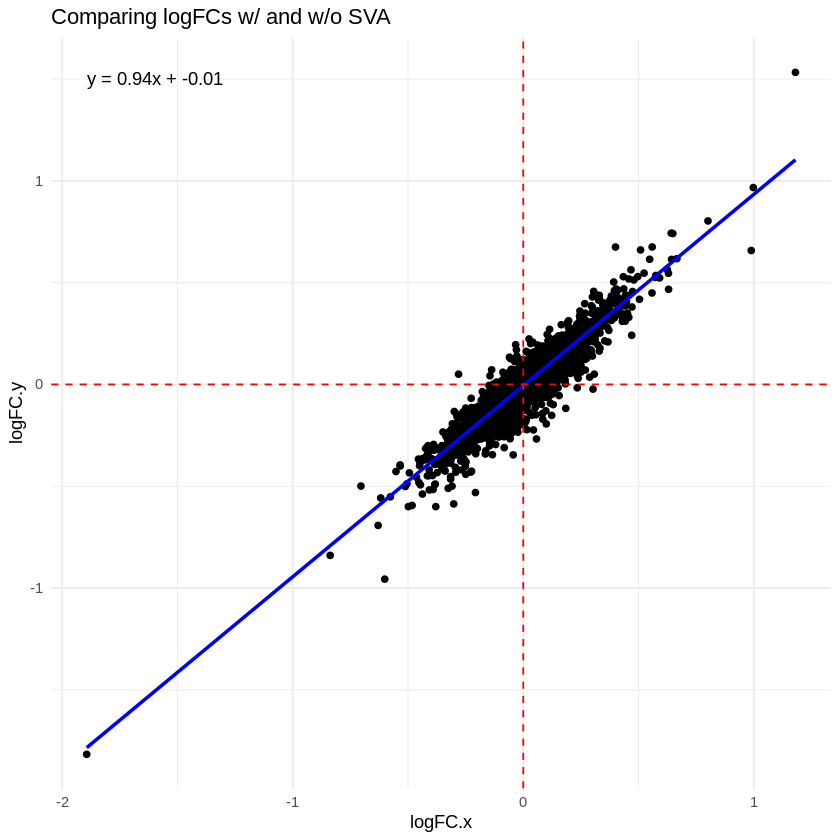

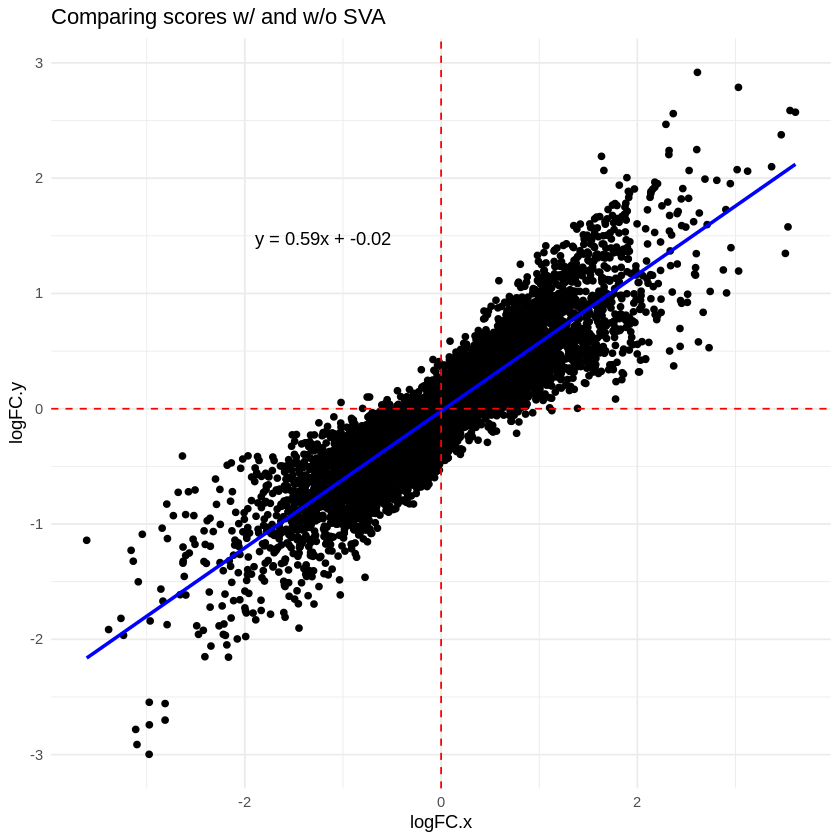

In [41]:
# Sanity check Nr2: compare to n.sv = 0

degs_all_no_sv = lapply(names(aggs)[!names(aggs)%in%c('Vascular')], function(x) RunDiffExprAnalysisLimma(aggs[[x]], metadata[[x]], n.sv=0))
names(degs_all_no_sv) = names(aggs)[!names(aggs)%in%c('Vascular')]
                        
x = degs_all$Ex$res
y = degs_all_no_sv$Ex$res
data = merge(x, y, by = 0)
data$score.x = sign(data$logFC.x) * -log10(data$P.Value.x)
data$score.y = sign(data$logFC.y) * -log10(data$P.Value.y)

# Load necessary library
library(ggplot2)

# Fit a linear model
model <- lm(logFC.y ~ logFC.x, data = data)
formula <- paste0("y = ", round(coef(model)[2], 2), "x + ", round(coef(model)[1], 2))

# Plot the data
ggplot(data, aes(x = logFC.x, y = logFC.y)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +  # Add linear regression line
  geom_vline(xintercept = 0, linetype = "dashed", color = "red") +  # Vertical line at 0
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +  # Horizontal line at 0
  labs(title = "Comparing logFCs w/ and w/o SVA",
       x = "logFC.x",
       y = "logFC.y") +
  annotate("text", x = min(data$logFC.x), y = max(data$logFC.y), label = formula, hjust = 0, vjust = 1) +  # Add formula annotation
  theme_minimal()

# Fit a linear model
model <- lm(score.y ~ score.x, data = data)
formula <- paste0("y = ", round(coef(model)[2], 2), "x + ", round(coef(model)[1], 2))

# Plot the data
ggplot(data, aes(x = score.x, y = score.y)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +  # Add linear regression line
  geom_vline(xintercept = 0, linetype = "dashed", color = "red") +  # Vertical line at 0
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +  # Horizontal line at 0
  labs(title = "Comparing scores w/ and w/o SVA",
       x = "logFC.x",
       y = "logFC.y") +
  annotate("text", x = min(data$logFC.x), y = max(data$logFC.y), label = formula, hjust = 0, vjust = 1) +  # Add formula annotation
  theme_minimal()

Number of significant surrogate variables is:  10 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  9 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  5 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  7 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  9 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  7 
Iteration (out of 5 ):1  2  3  4  5  

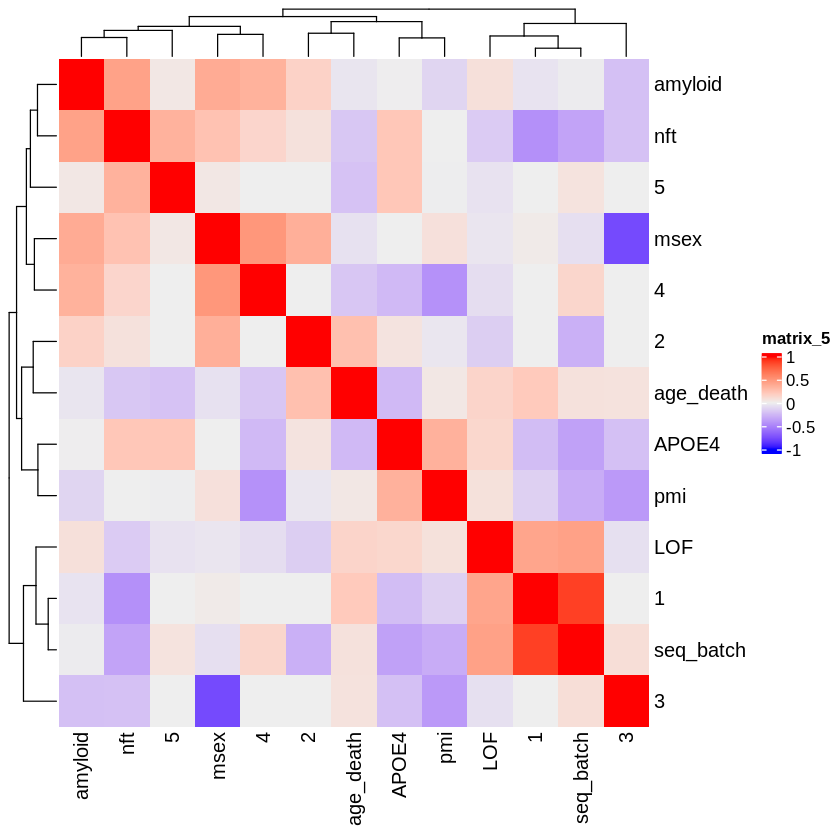

[1] 0.1744119

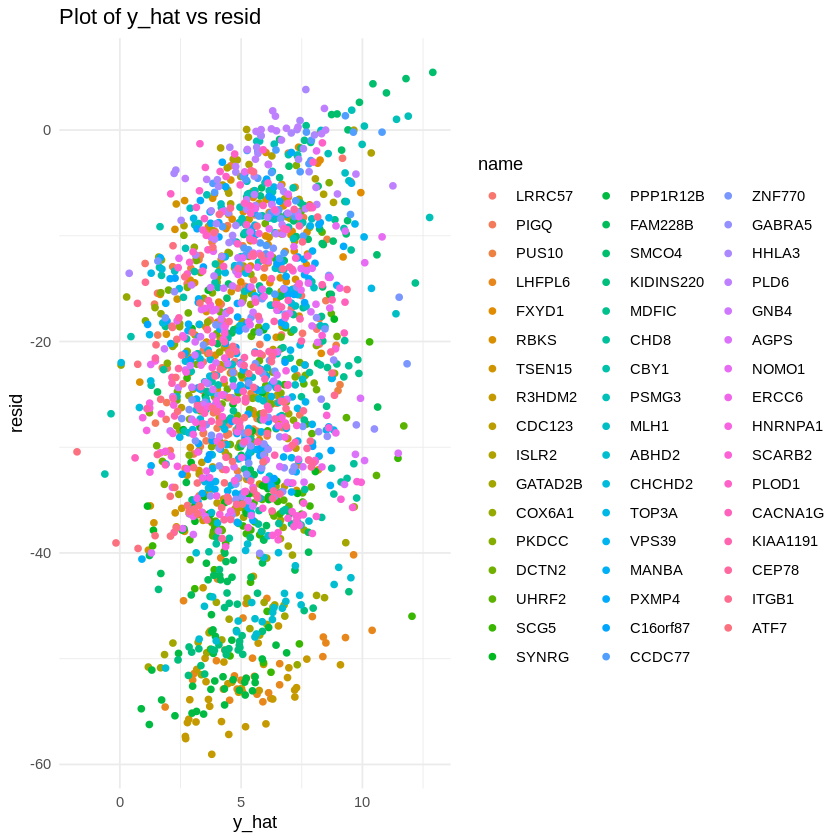


	Shapiro-Wilk normality test

data:  data[data$name == N, "resid"]
W = 0.96748, p-value = 0.3608


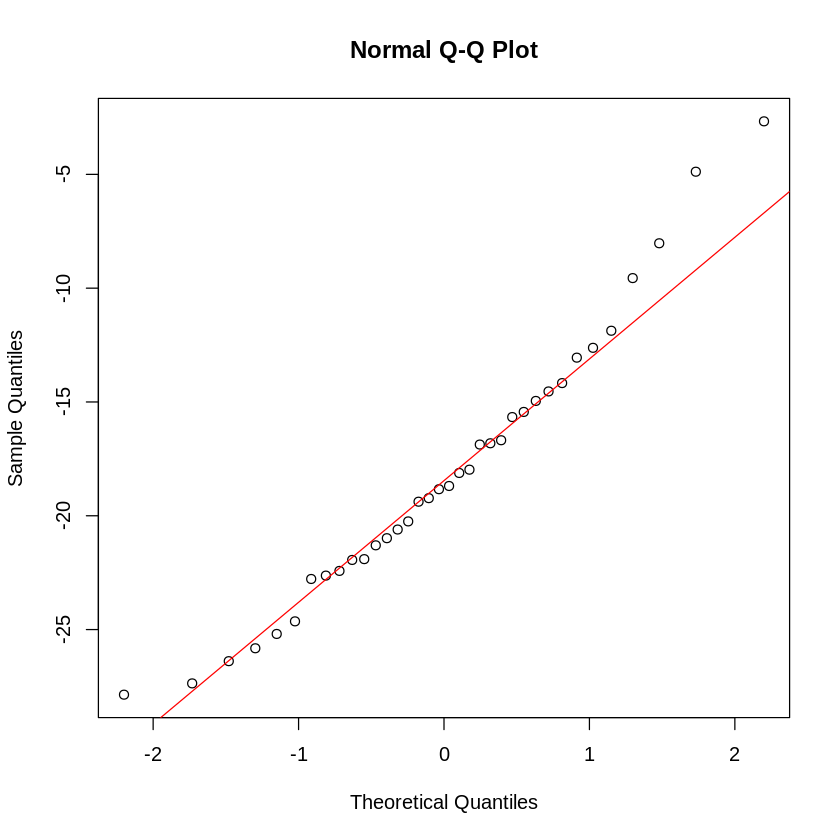

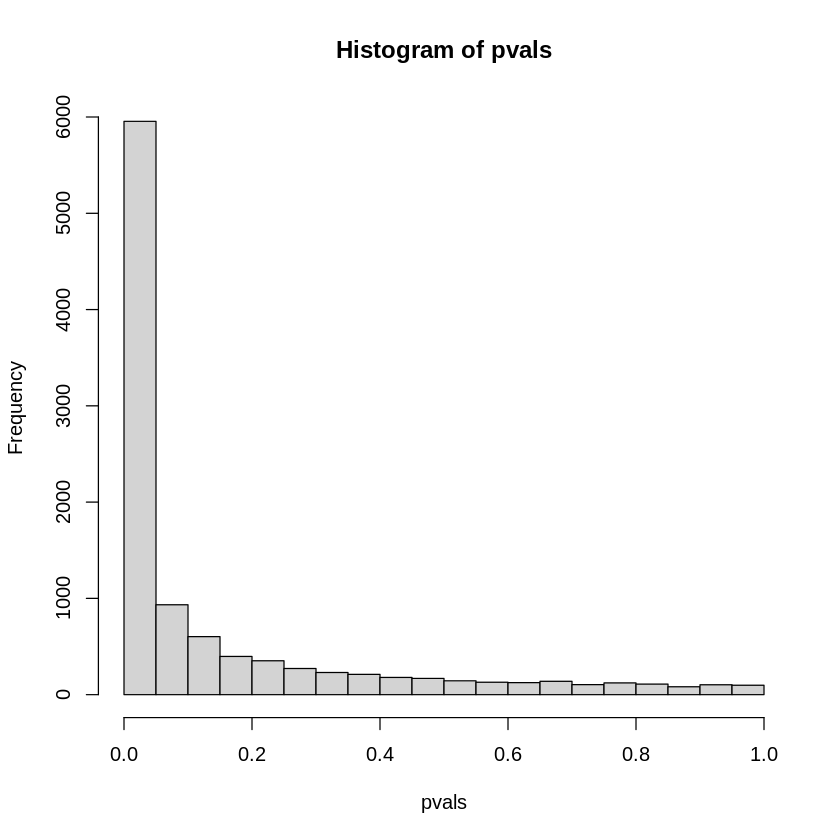

In [334]:
# Sanity checks Nr 3: Goodness of Fit

RunDiffExprAnalysisLimma_temp <- function(counts.df, var, n.sv=NULL, exclude_apoe=FALSE, exclude_batch=FALSE, exclude_both=FALSE) {
    
  # Computes differential expression using a combination of sva and voom-limma
  
  # Args:
  #   counts.df: data.frame with read counts (#genes x #samples)
  #   var: variable of interest
  #   genes.df: data.frame mapping gene IDs to gene names
  #   n.sv: number of surrogates for SVA. Automatically determined if NULL.
  #   exclude_apoe: Exclude APOE4 covariate from the model if TRUE.
  #   exclude_batch: Exclude batch effects covariate from the model if TRUE.
  #   exclude_both: Exclude both APOE4 and batch effects covariates from the model if TRUE.
  #
  # Returns:
  #   A list containing voom-limma output augmented with Storey q-values and SVA surrogate variables

    # apply edgeR normalization (TMM) to counts
    dge <- DGEList(counts=counts.df)
    dge <- calcNormFactors(dge)

    # apply voom transformation to normalized counts
    if(exclude_apoe==TRUE){
        mod1 <- model.matrix(~LOF + amyloid + nft + msex + age_death + pmi + seq_batch, data=var)
        mod0 <- model.matrix(~amyloid + nft + msex + age_death + pmi + seq_batch, data=var)
    }else if(exclude_batch==TRUE){
        mod1 <- model.matrix(~LOF + amyloid + nft + msex + age_death + pmi + APOE4, data=var)
        mod0 <- model.matrix(~amyloid + nft + msex + age_death + pmi + APOE4, data=var)
    }else if(exclude_both==TRUE){
        mod1 <- model.matrix(~LOF + amyloid + nft + msex + age_death + pmi, data=var)
        mod0 <- model.matrix(~amyloid + nft + msex + age_death + pmi, data=var)
    }else{
        mod1 <- model.matrix(~LOF + amyloid + nft + msex + age_death + pmi + seq_batch + APOE4, data=var)
        mod0 <- model.matrix(~amyloid + nft + msex + age_death + pmi + seq_batch + APOE4, data=var)
    }
    v <- voom(dge, design=mod1)

    if (is.null(n.sv)) {
        n.sv <- num.sv(v$E, mod1, method="be")
    }
    # calculate SVs on voom-transformed counts
    svobj <- sva(v$E, mod1, mod0, n.sv=n.sv)

    # re-calculate voom transformation w/ SVA covariates; run limma
    mod1 <- cbind(mod1, svobj$sv)  # intercept, var, SVs
    v <- voom(dge, design=mod1)
    fit <- lmFit(v, design=mod1)
    fit2 <- eBayes(fit)
    res <- topTable(fit2, coef='LOF', n=Inf, sort.by="p")

    return(list('fit'=fit, 'sv' = svobj$sv, 'v' = v, 'mod' = mod1, 'dge' = dge, 'res' = res))
}

degs_all = lapply(names(aggs)[!names(aggs)%in%c('Vascular')], function(x) RunDiffExprAnalysisLimma_temp(aggs[[x]], metadata[[x]], n.sv=NULL))
names(degs_all) = names(aggs)[!names(aggs)%in%c('Vascular')]
                  
# extract the data

mod_fit = degs_all$Ex$fit
svs = degs_all$Ex$sv
cpm = degs_all$Ex$v$E
cpm_weighted = cpm*sqrt(degs_all$Ex$v$weights)

temp = cbind(metadata[['Ex']], svs)
coeff = mod_fit$coefficients[,2:(ncol(mod_fit$coefficients))]
vals = apply(temp,2, function(x){as.numeric(x)})
y_hat = (vals%*%t(coeff)) + mod_fit$coefficients[,1]

# plot beta - correlation

library(ComplexHeatmap)
x = cor(vals)
Heatmap(x)

# extract the data

mod_fit = degs_all$Ex$fit
svs = degs_all$Ex$sv
cpm = degs_all$Ex$v$E
cpm_weighted = cpm*sqrt(degs_all$Ex$v$weights)

temp = cbind(metadata[['Ex']], svs)
coeff = mod_fit$coefficients[,2:(ncol(mod_fit$coefficients))]
vals = apply(temp,2, function(x){as.numeric(x)})
y_hat = (vals%*%t(coeff)) + mod_fit$coefficients[,1]

# plot beta - correlation

library(ComplexHeatmap)
x = cor(vals)
Heatmap(x)

# sample 1000 genes
library(reshape2)

y_true = t(cpm_weighted)
residuals = (y_hat-y_true)

samples <- runif(50, min = 0, max = ncol(residuals))

melted_y_hat = melt(y_hat[,samples])
melted_y_true = melt(y_true[,samples])
melted_resid = melt(residuals[,samples])

colnames(melted_y_hat) = c('x1', 'name', 'yhat')
colnames(melted_resid) = c('x', 'y', 'resid')

data = cbind(melted_y_hat, melted_resid)

library(ggplot2)
ggplot(data, aes(x = as.numeric(yhat), y = as.numeric(resid), color = name)) +
  geom_point() +
  labs(title = "Plot of y_hat vs resid",
       x = "y_hat",
       y = "resid") +
  theme_minimal() #+ ylim(0,100)
                  
# Check Normality of Residuals

y_true = t(cpm_weighted)
residuals = (y_hat-y_true)
pvals = apply(residuals, 2, function(x){shapiro.test(x)$p.value})
sum((pvals)<0.001)/length(pvals)

N = data$name[11]
qqnorm(data[data$name==N,'resid'])
qqline(data[data$name==N,'resid'], col = 'red')
shapiro.test(data[data$name==N,'resid'])

hist(pvals)
                  

In [6]:
# get the ids
ids = strsplit(colnames(summed_counts_indexed), '[.]')
ids = unlist(lapply(1:length(ids), function(x) ids[[x]][2]))

In [7]:
# compute degs (no APOE4 samples)
vars = c('LOF', 'amyloid', 'nft',  'msex', 'age_death', 'pmi', 'seq_batch')
sele = rownames(meta)[meta$APOE4==0]
sc_noAPOE4 = summed_counts_indexed[,ids%in%sele]
limma_inputs = get_limma_inputs(sc_noAPOE4, expressed, meta[sele,], vars)
aggs = limma_inputs$aggs
metadata = limma_inputs$metadata
degs_noAPOE4 = lapply(names(aggs)[!names(aggs)%in%c('Vascular')], function(x) RunDiffExprAnalysisLimma(aggs[[x]], metadata[[x]], n.sv=NULL, exclude_apoe=TRUE))
names(degs_noAPOE4) = names(aggs)[!names(aggs)%in%c('Vascular')]


Number of significant surrogate variables is:  6 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  6 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  4 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  5 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  5 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  5 
Iteration (out of 5 ):1  2  3  4  5  

In [8]:
# compute degs (no APOE4 samples)
vars = c('LOF', 'amyloid', 'nft',  'msex', 'age_death', 'pmi', 'APOE4')
sele = rownames(meta)[meta$seq_batch==1]
sc_JBM = summed_counts_indexed[,ids%in%sele]
limma_inputs = get_limma_inputs(sc_JBM, expressed, meta[sele,], vars)
aggs = limma_inputs$aggs
metadata = limma_inputs$metadata
degs_JBM = lapply(names(aggs)[!names(aggs)%in%c('Vascular')], function(x) RunDiffExprAnalysisLimma(aggs[[x]], metadata[[x]], n.sv=NULL, exclude_batch=TRUE))
names(degs_JBM) = names(aggs)[!names(aggs)%in%c('Vascular')]

Number of significant surrogate variables is:  5 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  4 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  3 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  5 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  3 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  3 
Iteration (out of 5 ):1  2  3  4  5  

In [9]:
# exclude both
vars = c('LOF', 'amyloid', 'nft',  'msex', 'age_death', 'pmi')
sele = rownames(meta)[(meta$seq_batch==1) & (meta$APOE4==0)]
sc_exclude_both = summed_counts_indexed[,ids%in%sele]
limma_inputs = get_limma_inputs(sc_exclude_both, expressed, meta[sele,], vars)
aggs = limma_inputs$aggs
metadata = limma_inputs$metadata
degs_exclude_both = lapply(names(aggs)[!names(aggs)%in%c('Vascular')], function(x) RunDiffExprAnalysisLimma(aggs[[x]], metadata[[x]], n.sv=NULL, exclude_both=TRUE))
names(degs_exclude_both) = names(aggs)[!names(aggs)%in%c('Vascular')]

Number of significant surrogate variables is:  4 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  4 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  4 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  3 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

In [11]:
# save the results
degs = list()
degs[['degs_all']] = degs_all
degs[['degs_exclude_both']] = degs_exclude_both
degs[['degs_JBM']] = degs_JBM
degs[['degs_noAPOE4']] = degs_noAPOE4

saveRDS(degs, './processed_data/single_cell/pseudobulk_degs_0825.rds')

In [12]:
# save deg scores as matrix
out = list()
scores = get_deg_scores(degs$degs_all)
for(i in names(scores)){
    df = as.data.frame(scores[[i]]$scores)
    colnames(df) = c('score')
    df$gene = rownames(df)
    df$celltype = i
    out[[i]] = df
}
all_scores = as.data.frame(do.call('rbind', out)%>%pivot_wider(., values_from='score', names_from='celltype'))
rownames(all_scores) = all_scores$gene
all_scores$gene = NULL
all_scores[is.na(all_scores)] = 0
write.csv(all_scores, './processed_data/single_cell/all_scores_0825.csv')

#### Run pathway enrichments (FGSEA)

In [2]:
# load degs
degs = readRDS('./processed_data/single_cell/pseudobulk_degs_0825.rds')$degs_all
scores = get_deg_scores(degs)

# compute fgsea results
all_paths = read.csv('./processed_data/genesets/all_paths.csv', row.names = 'X')
pathways = as.list(as.data.frame(t(all_paths)))
temp = lapply(names(pathways), function(x) pathways[[x]][!(pathways[[x]]=='')])
names(temp) = names(pathways)
              
out = lapply(names(scores), function(x) cbind(x, fgsea(pathways = temp, stats = scores[[x]]$scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)))
names(out) = names(scores)

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%



In [41]:
# save the fgsea results
saveRDS(out, './processed_data/for_plotting/fgsea_out_0825.rds')

# save all fgsea results
df = as.data.frame(do.call('rbind', out))
df = df[,!colnames(df)=='leadingEdge']
write.csv(df, './processed_data/for_plotting/fgsea_out_0825.csv')

# save LE genes per celltype
for(i in names(out)){
    res = out[[i]]
    res = res[res$pval<0.05,]

    df = as.data.frame(unique(unname(unlist(res$leadingEdge))))
    colnames(df) = 'gene'
    write.csv(df, paste0(paste0('./processed_data/for_plotting/leading_edge_0825', i), '.csv'))
}

In [42]:
# save all LEs
out = readRDS('./processed_data/for_plotting/fgsea_out_0825.rds')
res = do.call('rbind', out)
res$score = sign(res$NES) * -log10(res$pval)
res = res[order(res$pval,decreasing=FALSE),]
res = res[res$pval<0.05,]
# save all leading edge genes
df = as.data.frame(unique(unname(unlist(res$leadingEdge))))
colnames(df) = 'gene'
write.csv(df, './processed_data/for_plotting/leading_edge_0825.csv')

In [16]:
# save supp table
res = list()
for(i in names(out)){
    T = out[[i]]
    T = T[T$pval<0.05,]
    T = T[order(T$pval,decreasing=FALSE),]
    res[[i]] = T
}
temp = do.call('rbind', res)
temp2 = temp
x = unlist(lapply(temp$leadingEdge, function(x) paste(x, collapse=', ')))
temp$leadingEdge = x
write.csv(temp, './supplementary_tables/data_s3.csv')

In [3]:
out = readRDS('../../processed_data/fgsea_out_0825.rds')


In [10]:
data = out$Ex[order(out$Ex$pval, decreasing=FALSE),]
data$leadingEdge = unlist(lapply(data$leadingEdge, function(x) paste(x, collapse = ', ')))

write.csv(data,'/Users/djuna/Documents/ABCA7lof2/extended_tables/ex_fgsea.csv')


#### Save some additional data

In [15]:
# save deg supp table
degs = readRDS('./processed_data/single_cell/pseudobulk_degs_0825.rds')$degs_all
temp = lapply(names(degs), function(x) cbind(rownames(degs[[x]]$res), x, degs[[x]]$res))
temp = do.call('rbind', temp)
colnames(temp) = c('gene', 'cell_type', 'logFC', 'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B')
rownames(temp) = NULL
write.csv(temp, './supplementary_tables/data_s9.csv')